# Workflow

## Imports and Functions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_copy_data(num_samples, T, vocab_size):
    """
    Generate data for the copy task:
      - Input: [sequence] + [delimiter token] + [T zeros]
      - Target: [T+1 zeros] + [original sequence]
    """
    seq_length = 2 * T + 1
    X = np.zeros((num_samples, seq_length), dtype=np.int32)
    Y = np.zeros((num_samples, seq_length), dtype=np.int32)
    delimiter_token = vocab_size + 1
    for i in range(num_samples):
        random_seq = np.random.randint(1, vocab_size + 1, size=T)
        X[i, :T] = random_seq
        X[i, T] = delimiter_token
        Y[i, T+1:] = random_seq
    return X, Y

X shape: [ 4  5  6  9  2  6  4  4  7  3  9  5  4  9  8  7  9  8  1  3 11  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], Y shape: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 5 6 9 2 6 4 4 7 3 9 5 4 9 8 7
 9 8 1 3]


## CELLS and MODELS

### Standard LSTM Class

In [ ]:
class StandardLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(StandardLSTMCell, self).__init__()
        self.units = units
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros')

    def call(self, x, states):
        h_prev, c_prev = states
        i = tf.sigmoid(tf.matmul(x, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f = tf.sigmoid(tf.matmul(x, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o = tf.sigmoid(tf.matmul(x, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        c = f * c_prev + i * c_hat
        h = o * tf.tanh(c)
        return h, [h, c]

class StandardLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(StandardLSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size + 2, hidden_size)
        self.rnn = tf.keras.layers.RNN(StandardLSTMCell(hidden_size), return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')

    def call(self, inputs, initial_state=None, training=False):
        x = self.embedding(inputs)
        rnn_out, h, c = self.rnn(x, initial_state=initial_state) if initial_state is not None else self.rnn(x)
        return self.dense(rnn_out)

### Multiplicative LSTM Class

In [ ]:
class MultiplicativeLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(MultiplicativeLSTMCell, self).__init__()
        self.units = units
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_m = self.add_weight(shape=(input_dim, input_dim), initializer="random_normal", name="W_m")
        self.U_m = self.add_weight(shape=(self.units, input_dim), initializer="random_normal", name="U_m")
        self.b_m = self.add_weight(shape=(input_dim,), initializer="zeros", name="b_m")

        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_i")
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_i")
        self.b_i = self.add_weight(shape=(self.units,), initializer="zeros", name="b_i")

        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_f")
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_f")
        self.b_f = self.add_weight(shape=(self.units,), initializer="zeros", name="b_f")

        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_o")
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_o")
        self.b_o = self.add_weight(shape=(self.units,), initializer="zeros", name="b_o")

        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_c")
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_c")
        self.b_c = self.add_weight(shape=(self.units,), initializer="zeros", name="b_c")

    def call(self, x, states):
        h_prev, c_prev = states
        m_t = tf.matmul(x, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_tilde = m_t * x

        i = tf.sigmoid(tf.matmul(x_tilde, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f = tf.sigmoid(tf.matmul(x_tilde, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o = tf.sigmoid(tf.matmul(x_tilde, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_tilde, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        c = f * c_prev + i * c_hat
        h = o * tf.tanh(c)
        return h, [h, c]

class MultiplicativeLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(MultiplicativeLSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size + 2, hidden_size)
        self.rnn = tf.keras.layers.RNN(MultiplicativeLSTMCell(hidden_size), return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')

    def call(self, inputs, initial_state=None, training=False):
        x = self.embedding(inputs)
        rnn_out, h, c = self.rnn(x, initial_state=initial_state) if initial_state is not None else self.rnn(x)
        return self.dense(rnn_out)

### Standard GRU Class

In [ ]:
class StandardGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(StandardGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wz = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wz')
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uz')
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', name='bz')

        self.Wr = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wr')
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ur')
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', name='br')

        self.Wh = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wh')
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uh')
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', name='bh')

        super(StandardGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        z_t = tf.sigmoid(tf.matmul(inputs, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(inputs, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)
        h_tilde = tf.tanh(tf.matmul(inputs, self.Wh) + tf.matmul(r_t * h_prev, self.Uh) + self.bh)
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, [h_t]

class StandardGRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, **kwargs):
        super(StandardGRUModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.rnn = tf.keras.layers.RNN(StandardGRUCell(units), return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.rnn(x)
        return self.dense(x)

### Multiplicative GRU Class

In [ ]:
class MultiplicativeGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(MultiplicativeGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wm = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wm')
        self.Um = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Um')
        self.bm = self.add_weight(shape=(self.units,), initializer='zeros', name='bm')

        self.Wz = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wz')
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uz')
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', name='bz')

        self.Wr = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wr')
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ur')
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', name='br')

        self.Wh = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wh')
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uh')
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', name='bh')

        super(MultiplicativeGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        m_t = tf.matmul(inputs, self.Wm) + tf.matmul(h_prev, self.Um) + self.bm
        x_tilde = m_t * inputs
        z_t = tf.sigmoid(tf.matmul(x_tilde, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_tilde, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)
        h_tilde = tf.tanh(tf.matmul(x_tilde, self.Wh) + tf.matmul(r_t * h_prev, self.Uh) + self.bh)
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, [h_t]

class MultiplicativeGRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, **kwargs):
        super(MultiplicativeGRUModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.projection = tf.keras.layers.Dense(units) if embedding_dim != units else None
        self.rnn = tf.keras.layers.RNN(MultiplicativeGRUCell(units), return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        if self.projection is not None:
            x = self.projection(x)
        x = self.rnn(x)
        return self.dense(x)


## Training and Logging


Running for T = 100
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.4266 - loss: 2.2814 - val_accuracy: 0.5524 - val_loss: 1.5142
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5501 - loss: 1.3316 - val_accuracy: 0.5515 - val_loss: 1.1959
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5502 - loss: 1.1910 - val_accuracy: 0.5525 - val_loss: 1.1742
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5517 - loss: 1.1703 - val_accuracy: 0.5526 - val_loss: 1.1634
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5524 - loss: 1.1625 - val_accuracy: 0.5513 - val_loss: 1.1598
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5518 - loss: 1.1591 - val_accuracy: 0.5511 - val_loss: 1.1569
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.5520 - loss: 1.1563 - val_accuracy: 0.5531 - val_loss: 1.1545
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5505 - loss: 1.15

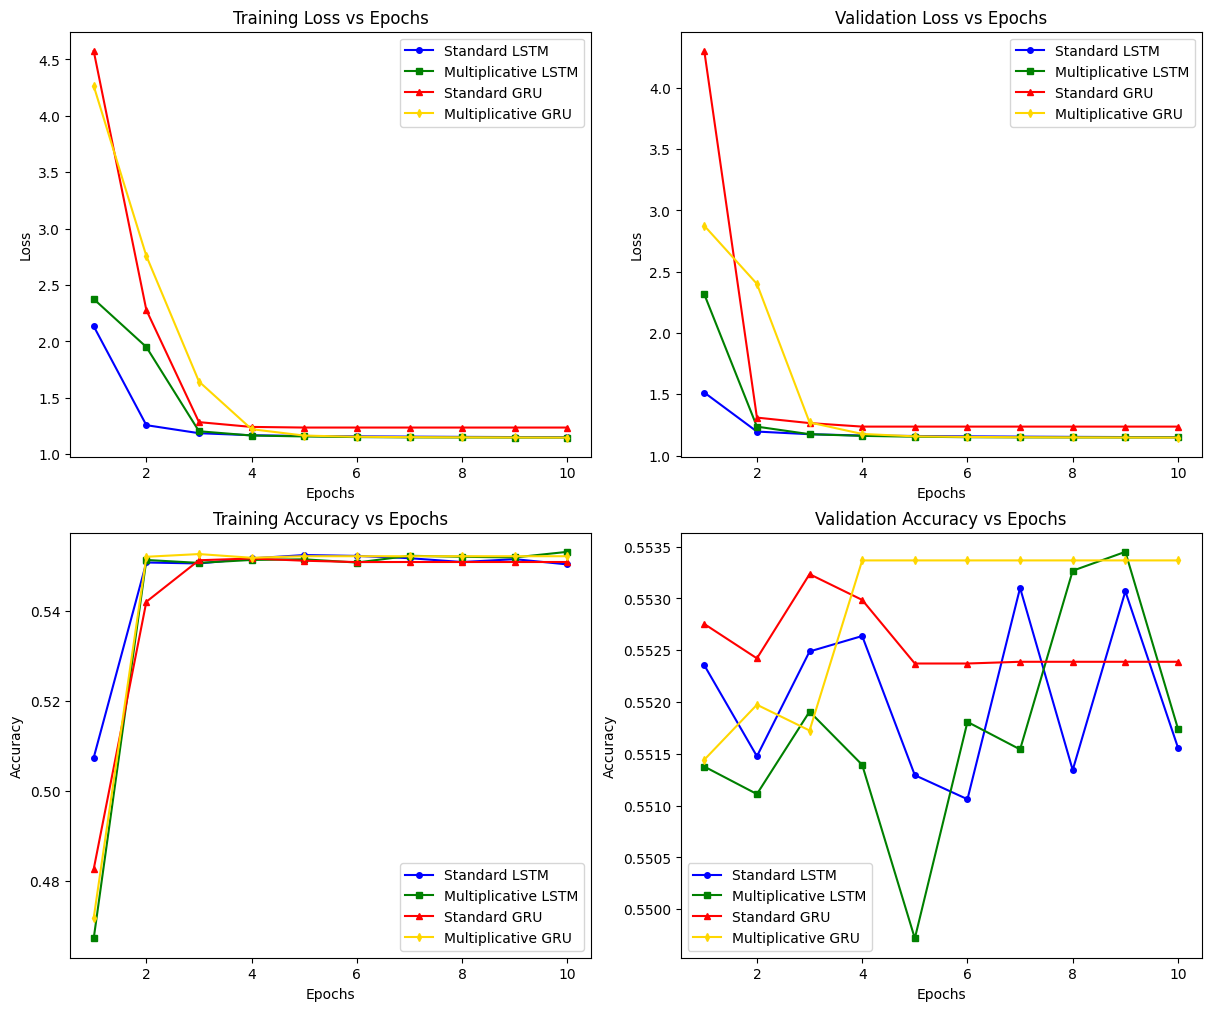


Running for T = 200
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.4359 - loss: 2.2576 - val_accuracy: 0.5505 - val_loss: 1.4203
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.5500 - loss: 1.2796 - val_accuracy: 0.5496 - val_loss: 1.1795
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5504 - loss: 1.1782 - val_accuracy: 0.5505 - val_loss: 1.1714
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.5509 - loss: 1.1692 - val_accuracy: 0.5499 - val_loss: 1.1642
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.5512 - loss: 1.1631 - val_accuracy: 0.5501 - val_loss: 1.1599
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5507 - loss: 1.1591 - val_accuracy: 0.5504 - val_loss: 1.1569
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5510 - loss: 1.1563 - val_accuracy: 0.5503 - val_loss: 1.1547
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.5511 - loss: 1.15

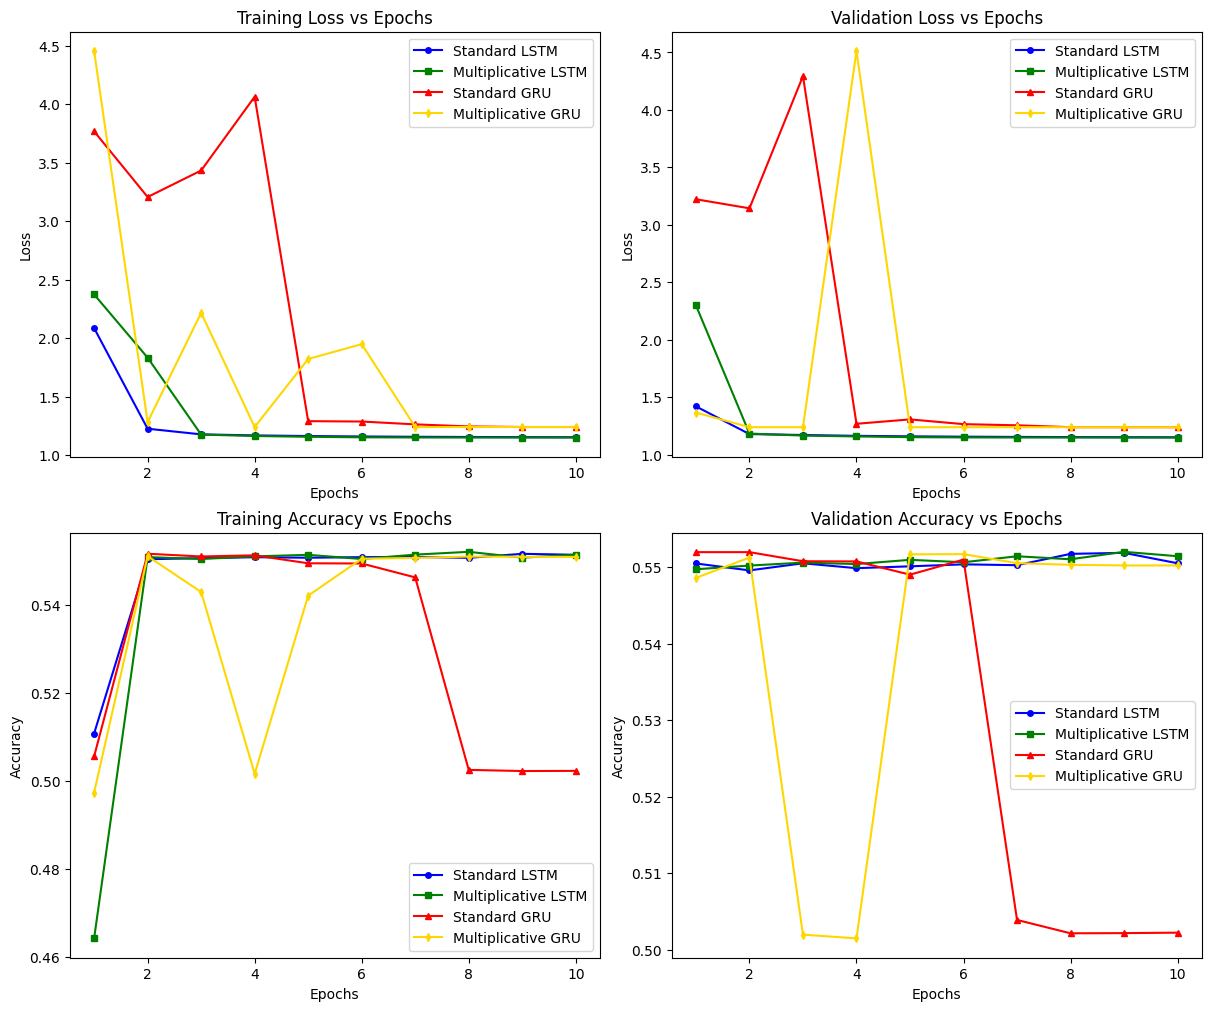


Running for T = 500
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.4209 - loss: 2.1848 - val_accuracy: 0.5501 - val_loss: 1.2350
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.5506 - loss: 1.1972 - val_accuracy: 0.5500 - val_loss: 1.1703
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.5507 - loss: 1.1697 - val_accuracy: 0.5500 - val_loss: 1.1680
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 608ms/step - accuracy: 0.5503 - loss: 1.1672 - val_accuracy: 0.5503 - val_loss: 1.1643
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 727ms/step - accuracy: 0.5501 - loss: 1.1634 - val_accuracy: 0.5501 - val_loss: 1.1603
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.5506 - loss: 1.1594 - val_accuracy: 0.5501 - val_loss: 1.1570
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 676ms/step - accuracy: 0.5505 - loss: 1.1564 - val_accuracy: 0.5503 - val_loss: 1.1548
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 628ms/step - accuracy: 0.5503 - loss: 

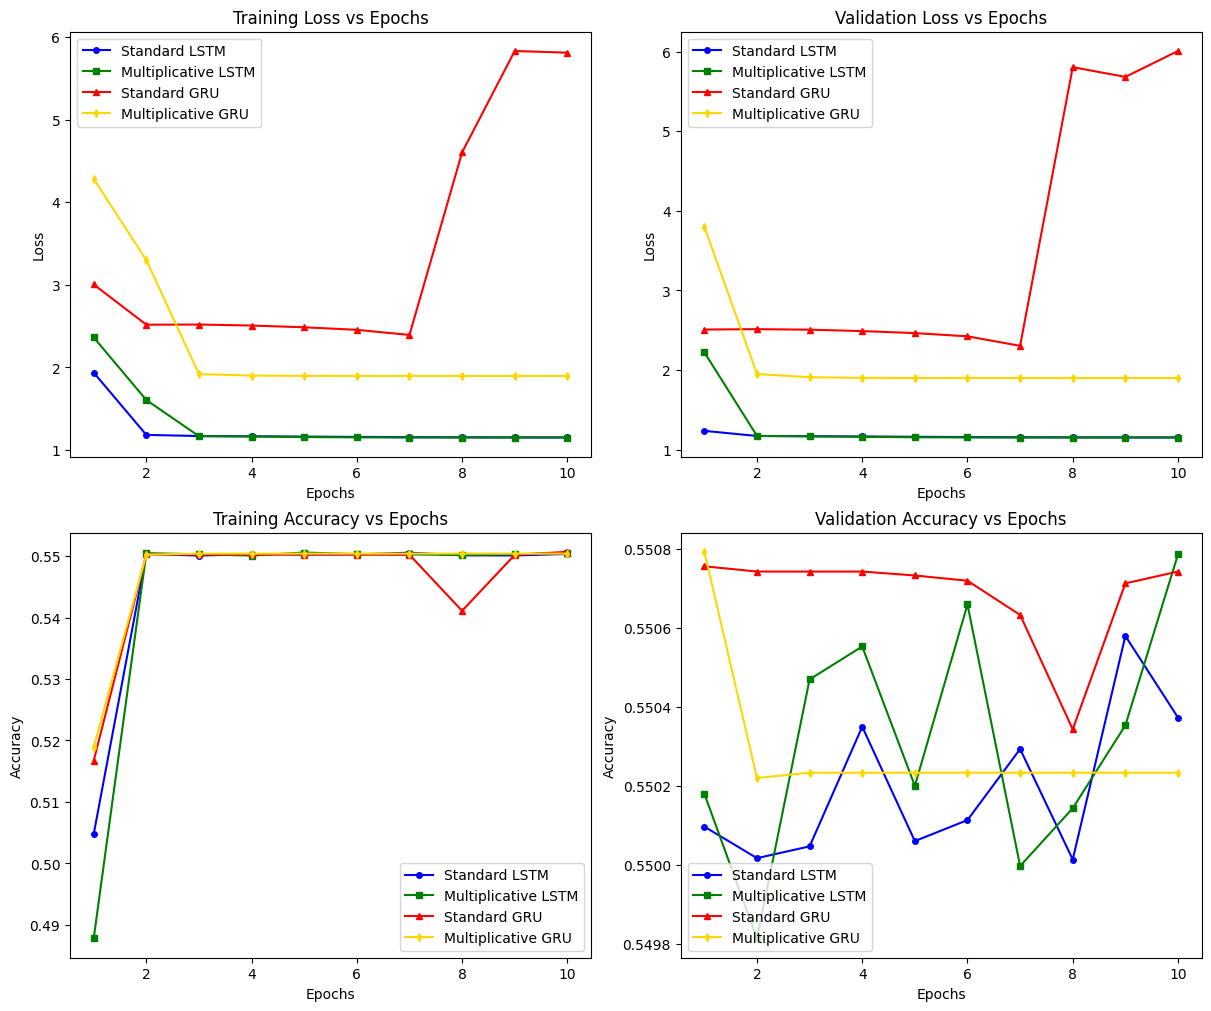


Running for T = 1000
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4337 - loss: 2.1317 - val_accuracy: 0.5501 - val_loss: 1.2000
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5501 - loss: 1.1815 - val_accuracy: 0.5497 - val_loss: 1.1657
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5501 - loss: 1.1650 - val_accuracy: 0.5501 - val_loss: 1.1631
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5503 - loss: 1.1623 - val_accuracy: 0.5501 - val_loss: 1.1595
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5501 - loss: 1.1586 - val_accuracy: 0.5497 - val_loss: 1.1563
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5499 - loss: 1.1557 - val_accuracy: 0.5506 - val_loss: 1.1543
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5501 - loss: 1.1540 - val_accuracy: 0.5497 - val_loss: 1.1532
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5503 - loss: 1.1530 - val_accura

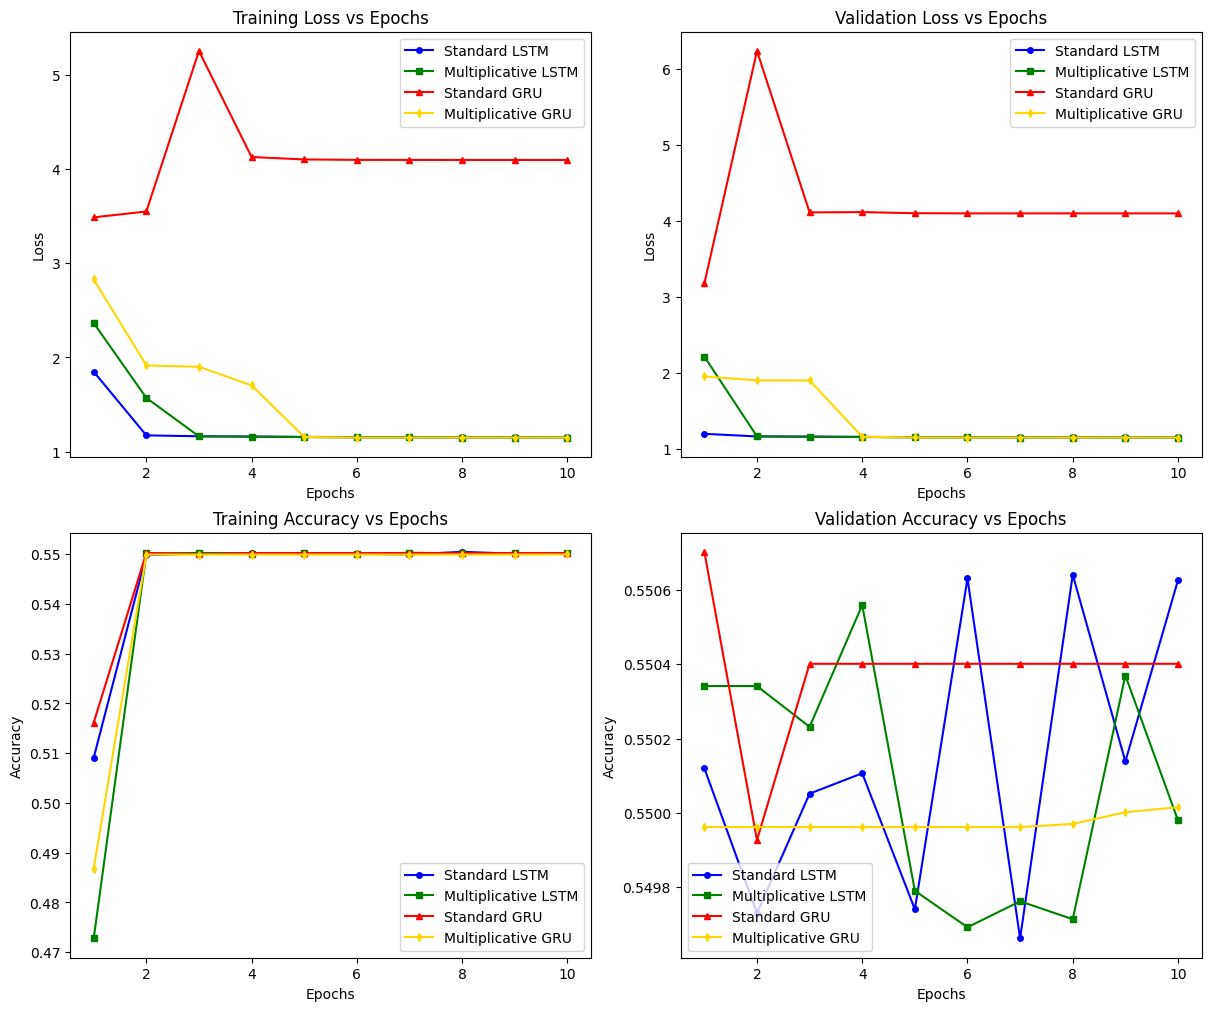

In [12]:
# Hyperparameters
num_samples = 1000
vocab_size = 10
hidden_size = 64
batch_size = 64
epochs = 10

records = []
for T in [100, 200, 500, 1000]:
    print(f"\nRunning for T = {T}")
    # Data generation and splitting
    X, Y = generate_copy_data(num_samples, T, vocab_size)
    split_index = int(0.7 * num_samples)
    X_train, Y_train = X[:split_index], Y[:split_index]
    X_val, Y_val = X[split_index:], Y[split_index:]
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(1000).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)


    # Training the models
    SLTSMmodel = StandardLSTMModel(vocab_size, hidden_size)
    SLTSMmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    SLTSM_history = SLTSMmodel.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    MLTSMmodel = MultiplicativeLSTMModel(vocab_size, hidden_size)
    MLTSMmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    MLTSM_history = MLTSMmodel.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    SGRUmodel = StandardGRUModel(vocab_size + 2, hidden_size, hidden_size)
    SGRUmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    SGRU_history = SGRUmodel.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    MGRUmodel = MultiplicativeGRUModel(vocab_size + 2, hidden_size, hidden_size)
    MGRUmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    MGRU_history = MGRUmodel.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    models = {
        'Standard LSTM': {'history': SLTSM_history, 'color': 'blue', 'marker': 'o'},
        'Multiplicative LSTM': {'history': MLTSM_history, 'color': 'green', 'marker': 's'},
        'Standard GRU': {'history': SGRU_history, 'color': 'red', 'marker': '^'},
        'Multiplicative GRU': {'history': MGRU_history, 'color': 'gold', 'marker': 'd'}
    }

    # Plotting the results
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
    epochs_range = range(1, len(SLTSM_history.history['loss']) + 1)

    # Subplot 1: Training Loss vs Epochs
    for name, props in models.items():
        axs[0, 0].plot(epochs_range, props['history'].history['loss'],
                    color=props['color'], marker=props['marker'], markersize=4, label=name)
    axs[0, 0].set_title('Training Loss vs Epochs')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Subplot 2: Validation Loss vs Epochs
    for name, props in models.items():
        axs[0, 1].plot(epochs_range, props['history'].history['val_loss'],
                    color=props['color'], marker=props['marker'], markersize=4, label=name)
    axs[0, 1].set_title('Validation Loss vs Epochs')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()


    # Subplot 3: Training Accuracy vs Epochs
    for name, props in models.items():
        axs[1, 0].plot(epochs_range, props['history'].history['accuracy'],
                    color=props['color'], marker=props['marker'], markersize=4, label=name)
    axs[1, 0].set_title('Training Accuracy vs Epochs')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    # Subplot 4: Validation Accuracy vs Epochs
    for name, props in models.items():
        axs[1, 1].plot(epochs_range, props['history'].history['val_accuracy'],
                    color=props['color'], marker=props['marker'], markersize=4, label=name)
    axs[1, 1].set_title('Validation Accuracy vs Epochs')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    plt.show()

    for model_name, props in models.items():
        history = props['history'].history
        for epoch in range(len(history['loss'])):
            records.append({
                'Epoch': epoch + 1,
                'Model': model_name,
                'Loss': history['loss'][epoch],
                'Accuracy': history['accuracy'][epoch],
                'Val Loss': history['val_loss'][epoch],
                'Val Accuracy': history['val_accuracy'][epoch],
                'T': T  # Sequence length used in data generation
            })


df = pd.DataFrame(records)
df.to_csv('results.csv', index=False)


# Individual Tests

## COMMON

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def generate_copy_data(num_samples, T, vocab_size):
    """
    Generate data for the copy task:
      - Input: [sequence] + [delimiter token] + [T zeros]
      - Target: [T+1 zeros] + [original sequence]
    """
    seq_length = 2 * T + 1
    X = np.zeros((num_samples, seq_length), dtype=np.int32)
    Y = np.zeros((num_samples, seq_length), dtype=np.int32)
    delimiter_token = vocab_size + 1
    for i in range(num_samples):
        random_seq = np.random.randint(1, vocab_size + 1, size=T)
        X[i, :T] = random_seq
        X[i, T] = delimiter_token
        Y[i, T+1:] = random_seq
    return X, Y

## STD LSTM

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.4246 - loss: 2.3568 - val_accuracy: 0.5546 - val_loss: 2.0881
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5534 - loss: 1.8501 - val_accuracy: 0.5487 - val_loss: 1.3382
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5496 - loss: 1.2964 - val_accuracy: 0.5546 - val_loss: 1.1958
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5585 - loss: 1.1833 - val_accuracy: 0.5578 - val_loss: 1.1647
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5588 - loss: 1.1623 - val_accuracy: 0.5586 - val_loss: 1.1561
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5611 - loss: 1.1541 - val_accuracy: 0.5598 - val_loss: 1.1504
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5616 - loss: 1.1491 - val_accuracy: 0.5594 - val_loss: 1.1462
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5605 - loss: 1.1451 - val_accuracy: 0.5598 - v

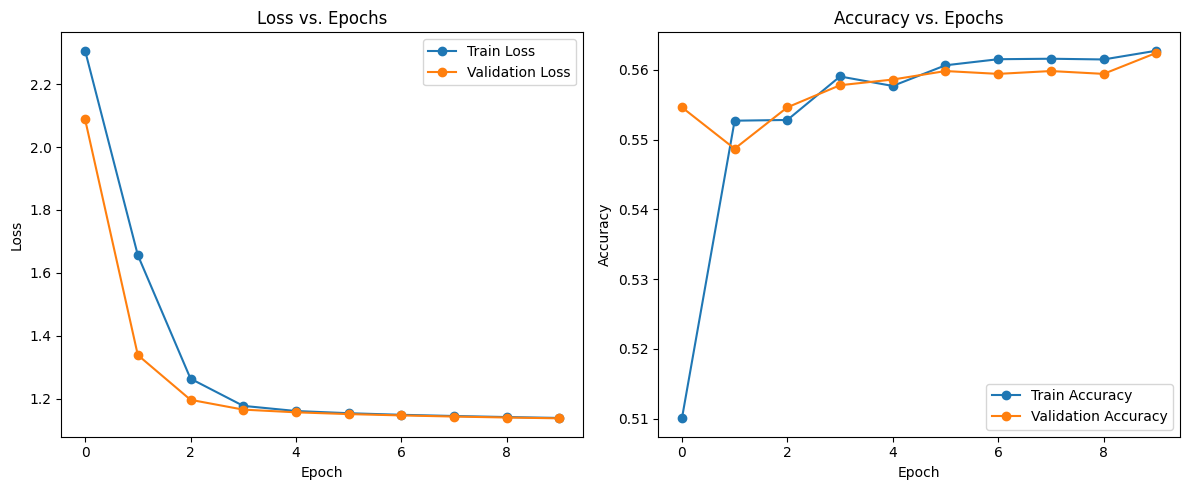

In [3]:
class StandardLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(StandardLSTMCell, self).__init__()
        self.units = units
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer='random_normal')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros')

    def call(self, x, states):
        h_prev, c_prev = states
        i = tf.sigmoid(tf.matmul(x, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f = tf.sigmoid(tf.matmul(x, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o = tf.sigmoid(tf.matmul(x, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        c = f * c_prev + i * c_hat
        h = o * tf.tanh(c)
        return h, [h, c]

class StandardLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(StandardLSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size + 2, hidden_size)
        self.rnn = tf.keras.layers.RNN(StandardLSTMCell(hidden_size), return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')

    def call(self, inputs, initial_state=None, training=False):
        x = self.embedding(inputs)
        rnn_out, h, c = self.rnn(x, initial_state=initial_state) if initial_state is not None else self.rnn(x)
        return self.dense(rnn_out)

# Hyperparameters
num_samples = 1000
vocab_size = 10
hidden_size = 64
batch_size = 64
epochs = 10
T = 20

# Data generation and splitting
X, Y = generate_copy_data(num_samples, T, vocab_size)
split_index = int(0.7 * num_samples)
X_train, Y_train = X[:split_index], Y[:split_index]
X_val, Y_val = X[split_index:], Y[split_index:]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)

model = StandardLSTMModel(vocab_size, hidden_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## MUL LSTM

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4057 - loss: 2.3890 - val_accuracy: 0.5122 - val_loss: 2.3476
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5143 - loss: 2.3023 - val_accuracy: 0.5457 - val_loss: 1.9326
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5475 - loss: 1.6993 - val_accuracy: 0.5553 - val_loss: 1.2788
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5585 - loss: 1.2404 - val_accuracy: 0.5593 - val_loss: 1.1722
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5638 - loss: 1.1638 - val_accuracy: 0.5612 - val_loss: 1.1479
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5657 - loss: 1.1441 - val_accuracy: 0.5612 - val_loss: 1.1364
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5624 - loss: 1.1345 - val_accuracy: 0.5609 - val_loss: 1.1315
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5631 - loss: 1.1302 - val_accuracy: 0.5609 - 

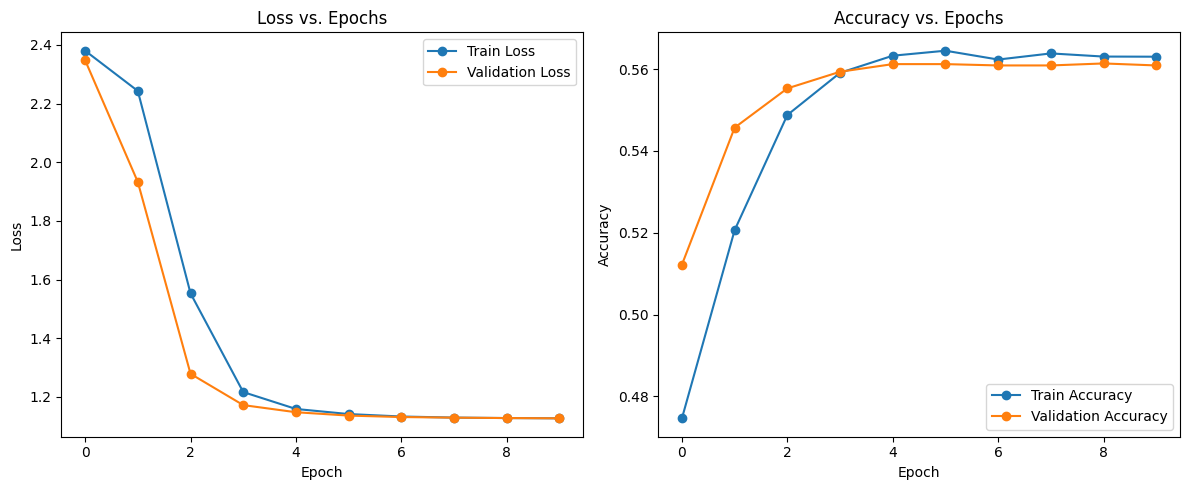

In [4]:
class MultiplicativeLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(MultiplicativeLSTMCell, self).__init__()
        self.units = units
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_m = self.add_weight(shape=(input_dim, input_dim), initializer="random_normal", name="W_m")
        self.U_m = self.add_weight(shape=(self.units, input_dim), initializer="random_normal", name="U_m")
        self.b_m = self.add_weight(shape=(input_dim,), initializer="zeros", name="b_m")
        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_i")
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_i")
        self.b_i = self.add_weight(shape=(self.units,), initializer="zeros", name="b_i")
        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_f")
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_f")
        self.b_f = self.add_weight(shape=(self.units,), initializer="zeros", name="b_f")
        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_o")
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_o")
        self.b_o = self.add_weight(shape=(self.units,), initializer="zeros", name="b_o")
        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer="random_normal", name="W_c")
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer="random_normal", name="U_c")
        self.b_c = self.add_weight(shape=(self.units,), initializer="zeros", name="b_c")

    def call(self, x, states):
        h_prev, c_prev = states
        m_t = tf.matmul(x, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_tilde = m_t * x
        i = tf.sigmoid(tf.matmul(x_tilde, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f = tf.sigmoid(tf.matmul(x_tilde, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o = tf.sigmoid(tf.matmul(x_tilde, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_tilde, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        c = f * c_prev + i * c_hat
        h = o * tf.tanh(c)
        return h, [h, c]

class MultiplicativeLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, hidden_size):
        super(MultiplicativeLSTMModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size + 2, hidden_size)
        self.rnn = tf.keras.layers.RNN(MultiplicativeLSTMCell(hidden_size), return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')

    def call(self, inputs, initial_state=None, training=False):
        x = self.embedding(inputs)
        rnn_out, h, c = self.rnn(x, initial_state=initial_state) if initial_state is not None else self.rnn(x)
        return self.dense(rnn_out)


# Hyperparameters
num_samples = 1000
vocab_size = 10
hidden_size = 64
batch_size = 64
epochs = 10
T = 20

# Data generation and splitting
X, Y = generate_copy_data(num_samples, T, vocab_size)
split_index = int(0.7 * num_samples)
X_train, Y_train = X[:split_index], Y[:split_index]
X_val, Y_val = X[split_index:], Y[split_index:]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)

model = MultiplicativeLSTMModel(vocab_size, hidden_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## STD GRU

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4113 - loss: 5.0175 - val_accuracy: 0.5560 - val_loss: 4.1487
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5611 - loss: 4.0824 - val_accuracy: 0.5592 - val_loss: 4.0393
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5588 - loss: 3.9742 - val_accuracy: 0.5602 - val_loss: 4.4466
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5610 - loss: 3.9387 - val_accuracy: 0.5565 - val_loss: 3.8136
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5264 - loss: 3.4605 - val_accuracy: 0.5204 - val_loss: 5.4371
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5327 - loss: 5.1492 - val_accuracy: 0.5611 - val_loss: 4.3673
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5607 - loss: 4.1619 - val_accuracy: 0.5583 - val_loss: 3.8027
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5606 - loss: 3.7338 - val_accuracy: 0.5596 - v

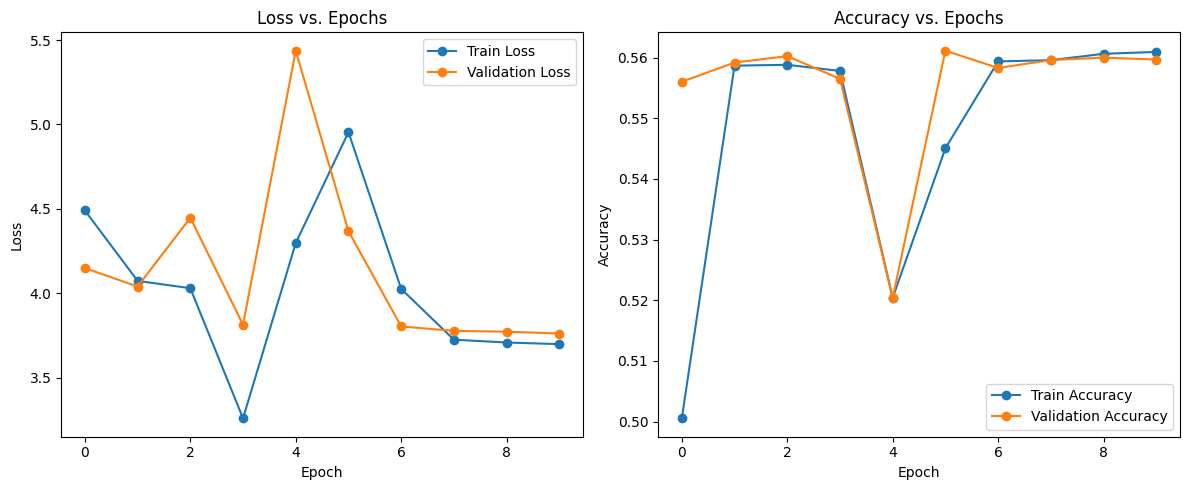

In [5]:
class StandardGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(StandardGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wz = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wz')
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uz')
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', name='bz')

        self.Wr = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wr')
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ur')
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', name='br')

        self.Wh = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wh')
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uh')
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', name='bh')

        super(StandardGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        z_t = tf.sigmoid(tf.matmul(inputs, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(inputs, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)
        h_tilde = tf.tanh(tf.matmul(inputs, self.Wh) + tf.matmul(r_t * h_prev, self.Uh) + self.bh)
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, [h_t]

class StandardGRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, **kwargs):
        super(StandardGRUModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.rnn = tf.keras.layers.RNN(StandardGRUCell(units), return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.rnn(x)
        return self.dense(x)

# Hyperparameters
num_samples = 1000
vocab_size = 10
hidden_size = 64
batch_size = 64
epochs = 10
T = 20

# Data generation and splitting
X, Y = generate_copy_data(num_samples, T, vocab_size)
split_index = int(0.7 * num_samples)
X_train, Y_train = X[:split_index], Y[:split_index]
X_val, Y_val = X[split_index:], Y[split_index:]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)

model = StandardGRUModel(vocab_size + 2, hidden_size, hidden_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## MUL GRU

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3927 - loss: 4.7510 - val_accuracy: 0.5122 - val_loss: 4.1085
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5122 - loss: 3.9853 - val_accuracy: 0.5122 - val_loss: 3.9718
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5122 - loss: 3.8793 - val_accuracy: 0.5122 - val_loss: 3.9004
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5211 - loss: 3.7429 - val_accuracy: 0.5537 - val_loss: 3.7285
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5562 - loss: 3.6121 - val_accuracy: 0.5571 - val_loss: 3.3832
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5591 - loss: 3.3744 - val_accuracy: 0.5596 - val_loss: 3.3863
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5591 - loss: 3.4501 - val_accuracy: 0.5335 - val_loss: 3.7555
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5192 - loss: 3.6234 - val_accuracy: 0.5190 - v

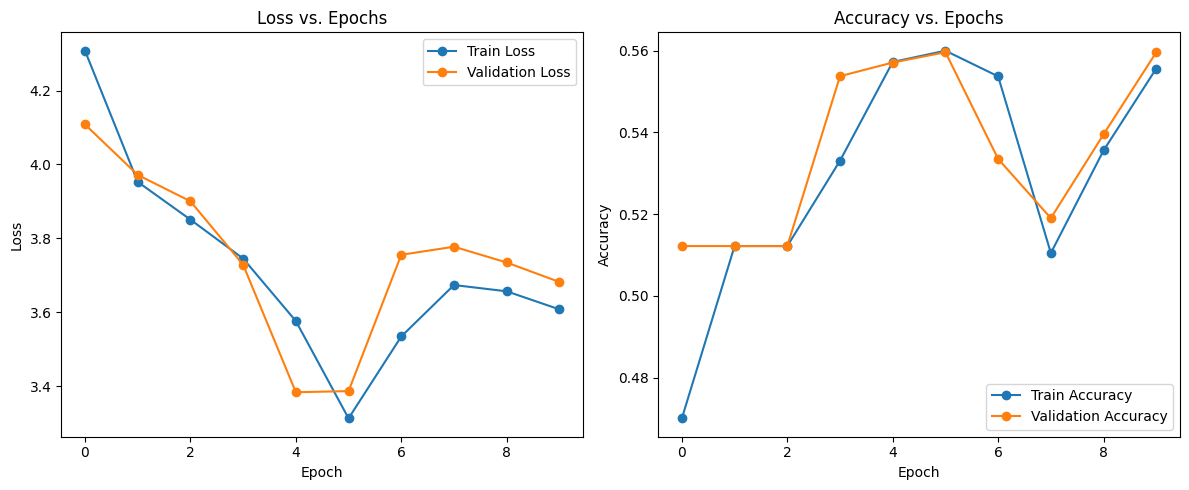

In [6]:
class MultiplicativeGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(MultiplicativeGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wm = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='Wm')
        self.Um = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Um')
        self.bm = self.add_weight(shape=(self.units,), initializer='zeros', name='bm')

        self.Wz = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wz')
        self.Uz = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uz')
        self.bz = self.add_weight(shape=(self.units,), initializer='zeros', name='bz')

        self.Wr = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wr')
        self.Ur = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Ur')
        self.br = self.add_weight(shape=(self.units,), initializer='zeros', name='br')

        self.Wh = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='Wh')
        self.Uh = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='Uh')
        self.bh = self.add_weight(shape=(self.units,), initializer='zeros', name='bh')

        super(MultiplicativeGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        m_t = tf.matmul(inputs, self.Wm) + tf.matmul(h_prev, self.Um) + self.bm
        x_tilde = m_t * inputs
        z_t = tf.sigmoid(tf.matmul(x_tilde, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_tilde, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)
        h_tilde = tf.tanh(tf.matmul(x_tilde, self.Wh) + tf.matmul(r_t * h_prev, self.Uh) + self.bh)
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t, [h_t]

class MultiplicativeGRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, **kwargs):
        super(MultiplicativeGRUModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.projection = tf.keras.layers.Dense(units) if embedding_dim != units else None
        self.rnn = tf.keras.layers.RNN(MultiplicativeGRUCell(units), return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        if self.projection is not None:
            x = self.projection(x)
        x = self.rnn(x)
        return self.dense(x)

# Hyperparameters
num_samples = 1000
vocab_size = 10
hidden_size = 64
batch_size = 64
epochs = 10
T = 20

# Data generation and splitting
X, Y = generate_copy_data(num_samples, T, vocab_size)
split_index = int(0.7 * num_samples)
X_train, Y_train = X[:split_index], Y[:split_index]
X_val, Y_val = X[split_index:], Y[split_index:]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size)

model = MultiplicativeGRUModel(vocab_size + 2, hidden_size, hidden_size)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()